<a href="https://colab.research.google.com/github/jerryjerry9/FRI_ML/blob/main/pytorch_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [178]:
import numpy as np
import seaborn as sn

In [179]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [180]:
torch.cuda.is_available()

True

In [181]:
training_data = datasets.FashionMNIST(
    root="data",            # 資料放置路徑
    train=True,             # 訓練資料集
    download=True,          # 自動下載
    transform=ToTensor(),   # 資料轉換函數
)

In [182]:
test_data = datasets.FashionMNIST(
    root="data",            # 資料放置路徑
    train=False,            # 測試資料集
    download=True,          # 自動下載
    transform=ToTensor(),   # 資料轉換函數
)

In [183]:
# 批次載入資料筆數
batch_size = 64

# 建立 DataLoader
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [184]:
size = len(train_dataloader.dataset)
num_batches = len(train_dataloader)
test_size = len(test_dataloader.dataset)
test_num_batches = len(test_dataloader)

In [185]:
print(size,num_batches)
print(test_size,test_num_batches)

60000 938
10000 157


In [186]:
for X, y in train_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [187]:
dataiter = iter(test_dataloader)
data = dataiter.next()
feature, labels = data
print(feature.shape)


torch.Size([64, 1, 28, 28])


In [ ]:
i=17
aaa = feature[i,0,:,:]
print(aaa.shape)
print(labels[i])


torch.Size([28, 28])
tensor(4)


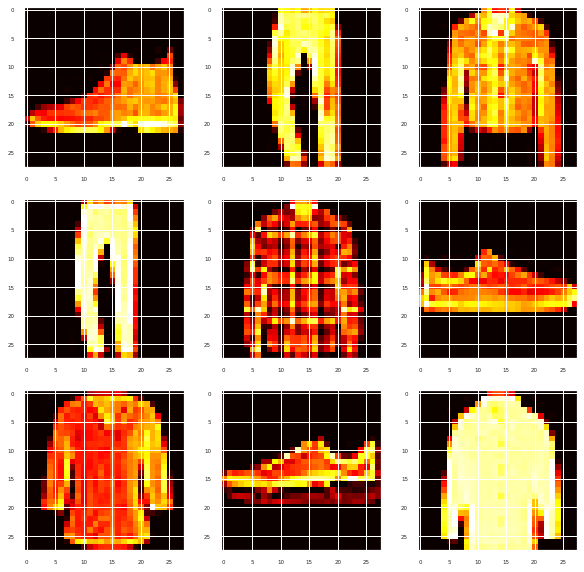

In [242]:

fig, ax = plt.subplots(3,3,figsize=(10,10))
for i in range(0,3):
  for j in range(0,3):
    k = i*2 +j*5
    ax[i,j].imshow(feature[k,0,:,:],cmap='hot')


In [188]:
# 定義類神經網路模型
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        # 建立類神經網路各層
        self.flatten = nn.Flatten()  # 轉為一維向量
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),   # 線性轉換
            nn.ReLU(),               # ReLU 轉換
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        # 定義資料如何通過類神經網路各層
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [189]:
# 若 CUDA 環境可用，則使用 GPU 計算，否則使用 CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [190]:
# 建立類神經網路模型，並放置於 GPU 或 CPU 上
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [191]:
# 損失函數
loss_fn = nn.CrossEntropyLoss()

# 學習優化器
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [192]:
# 訓練模型
def train(dataloader, model, loss_fn, optimizer):
    # 資料總筆數
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # 將模型設定為訓練模式
    model.train()
    train_loss = 0
    # 批次讀取資料進行訓練
    for batch, (X, y) in enumerate(dataloader):
        # 將資料放置於 GPU 或 CPU
        X, y = X.to(device), y.to(device)

        pred = model(X)         # 計算預測值
        loss = loss_fn(pred, y) # 計算損失值（loss）
        train_loss += loss_fn(pred, y).item()
        optimizer.zero_grad()   # 重設參數梯度（gradient）
        loss.backward()         # 反向傳播（backpropagation）
        optimizer.step()        # 更新參數
    train_loss /= num_batches
    return(train_loss)
        # 輸出訓練過程資訊
        #if batch % 100 == 0:
        #    loss, current = loss.item(), batch * len(X)
        #    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        

In [193]:
# 測試模型
def test(dataloader, model, loss_fn):
    # 資料總筆數
    size = len(dataloader.dataset)

    # 批次數量
    num_batches = len(dataloader)

    # 將模型設定為驗證模式
    model.eval()

    # 初始化數值
    test_loss, correct = 0, 0

    # 驗證模型準確度
    with torch.no_grad():  # 不要計算參數梯度
        for X, y in dataloader:
            # 將資料放置於 GPU 或 CPU
            X, y = X.to(device), y.to(device)

            # 計算預測值
            pred = model(X)

            # 計算損失值的加總值
            test_loss += loss_fn(pred, y).item()

            # 計算預測正確數量的加總值
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # 計算平均損失值與正確率
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [ ]:
# 設定 epochs 數
epochs = 50
total_trainloss = np.zeros((epochs)) 
total_testloss = np.zeros((epochs)) 
# 開始訓練模型
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    trainloss = train(train_dataloader, model, loss_fn, optimizer)
    testloss = test(test_dataloader, model, loss_fn)
    total_trainloss[t] = trainloss
    total_testloss[t] = testloss
print('done')

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 71.7%, Avg loss: 0.763794 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 72.8%, Avg loss: 0.741455 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 73.7%, Avg loss: 0.721755 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 74.6%, Avg loss: 0.704026 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 75.4%, Avg loss: 0.687850 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 76.1%, Avg loss: 0.672963 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 76.9%, Avg loss: 0.659220 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.646533 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.634820 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.624003 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 78.9%, Avg los

In [ ]:
# 儲存模型參數
torch.save(model.state_dict(), "drive/MyDrive/ml_data/hw01/model.pth")

In [194]:
# 建立類神經網路模型
model2 = NeuralNetwork()

# 載入模型參數
model2.load_state_dict(torch.load("drive/MyDrive/ml_data/hw01/model.pth"))

<All keys matched successfully>

In [ ]:
print(total_trainloss)
print(total_testloss)

[0.76097663 0.73634801 0.71493443 0.69584663 0.67852506 0.66261819
 0.64791524 0.63429131 0.62166676 0.60996163 0.59910576 0.58903609
 0.5797033  0.57104005 0.56298114 0.55547327 0.5484667  0.54191654
 0.53578317 0.53002925 0.52462103 0.51953364 0.514743   0.5102185
 0.50594242 0.50189464 0.4980519  0.49440467 0.49093784 0.4876384
 0.48449662 0.4814971  0.47862746 0.47587995 0.4732483  0.47072109
 0.46828944 0.46594831 0.46369482 0.46152148 0.45942224 0.45739237
 0.45542925 0.45352801 0.45168192 0.44988914 0.44814499 0.44643824
 0.44476875 0.44313268]
[0.76379389 0.74145514 0.72175498 0.7040261  0.68785045 0.6729634
 0.65922042 0.64653267 0.63482035 0.62400264 0.61402232 0.60480737
 0.59629949 0.58842282 0.58111972 0.57432728 0.56800247 0.56210338
 0.55658514 0.55141254 0.54655452 0.54199309 0.53770121 0.53365554
 0.52983729 0.52621458 0.52278157 0.51952053 0.51642597 0.51348418
 0.51068473 0.50800671 0.50545204 0.50301353 0.50068099 0.49844359
 0.49629628 0.49423495 0.49225716 0.49034

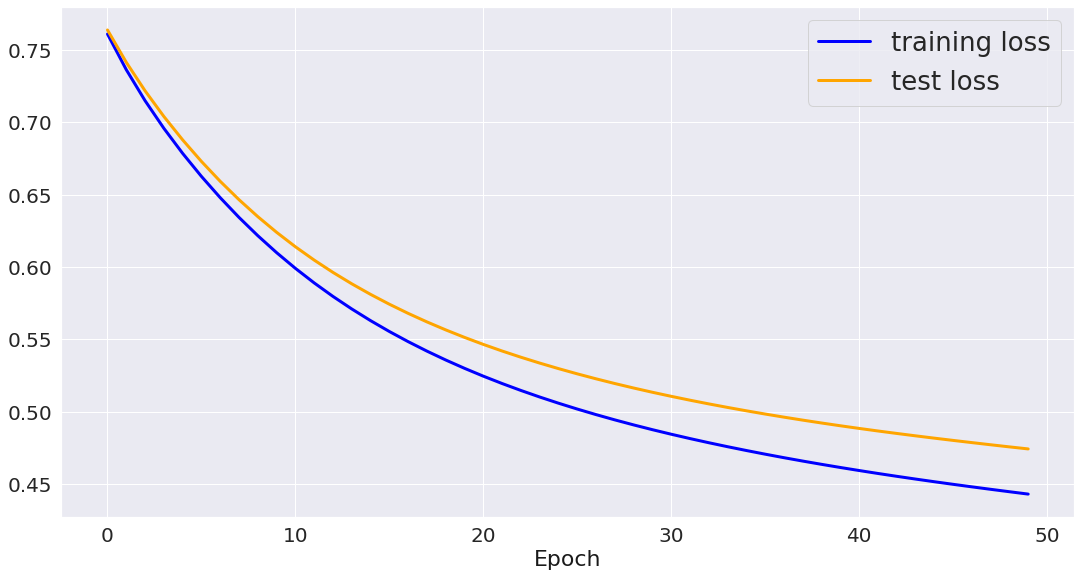

In [ ]:
f= plt.figure(figsize=(15,8))
plt.plot(total_trainloss,linewidth=3,c='blue')
plt.plot(total_testloss,linewidth=3,c='orange')
plt.legend(["training loss","test loss"],fontsize=26)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Epoch',color='k',fontsize=22)
plt.tight_layout()
plt.savefig('drive/MyDrive/ml_data/hw01/loss.png',dpi=400)

In [206]:
# 各類別名稱
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
cm=np.zeros((10,10))
# 將模型設定為驗證模式
model2.eval()
for x,y in test_data:
# 取得測試資料
  #print(x)
  pred = model2(x)
  cm[pred[0].argmax(0),y]=cm[pred[0].argmax(0),y]+1

    # 整理測試結果
    #predicted, actual = classes[pred[0].argmax(0)], classes[y]
    #print(f'預測值："{predicted}" / 實際值："{actual}"')

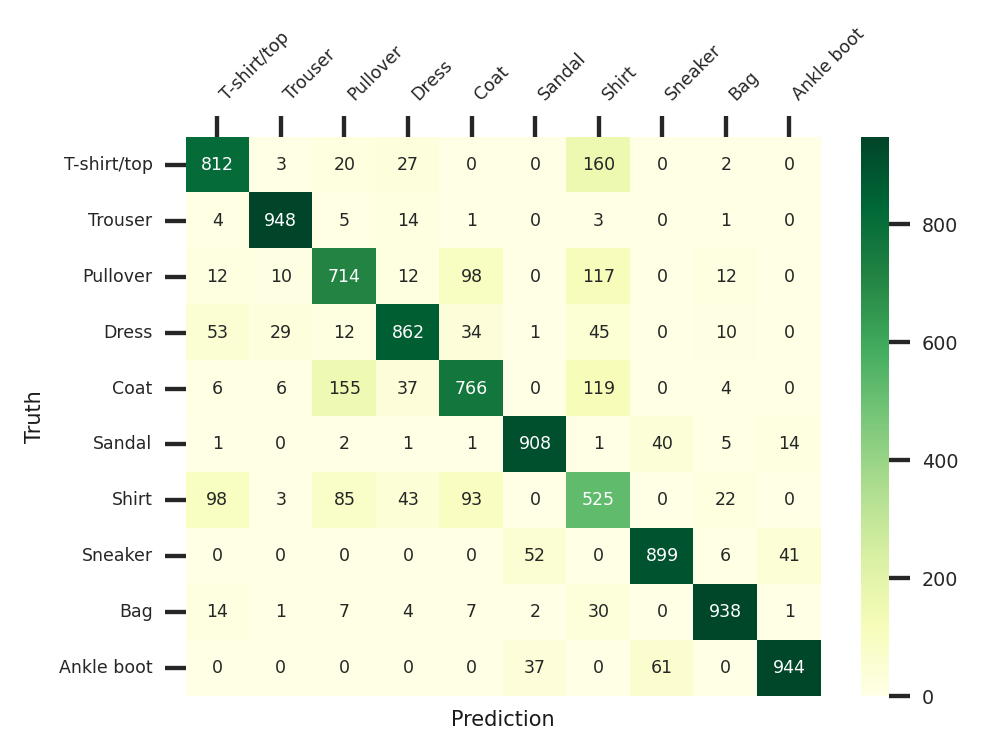

In [207]:
fig, ax = plt.subplots(figsize=(4,3),dpi=250)
ax = sn.heatmap(cm,xticklabels=classes,yticklabels=classes,annot=True,fmt = 'g',cmap='YlGn',annot_kws={'fontsize':5},cbar=True)
ax.yaxis.tick_left()
plt.yticks(rotation=0,fontsize=5)

ax.xaxis.tick_top()
plt.xticks(ha='left',rotation=45,fontsize=5)
plt.ylabel('Truth',color='k',fontsize=6)
plt.xlabel('Prediction',color='k',fontsize=6)
plt.tight_layout()
plt.savefig('drive/MyDrive/ml_data/hw01/heatmap.png',dpi=400)